In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [2]:
DIRECTORY = './data/'
categories = pd.read_csv(DIRECTORY + 'item_categories.csv')
items = pd.read_csv(DIRECTORY + 'items.csv')
shops = pd.read_csv(DIRECTORY + 'shops.csv')
train = pd.read_csv(DIRECTORY + 'sales_train.csv')

# Backtest Engine

MSE: 7.199543990964109
MSE: 8.262359776986633
MSE: 5.632298034335078
MSE: 5.304273802561829
MSE: 6.3951943475603175
MSE: 5.006612389075558
MSE: 6.021948571231602
MSE: 8.618899660688317
MSE: 7.7809830965261675
MSE: 8.981869413136417
MSE: 11.07565366642975
MSE: 6.352738184546136
MSE: 7.3715830957571695
MSE: 7.429436521166471
MSE: 5.706437223308389
MSE: 6.065102914827602
MSE: 5.821523848454207
MSE: 4.824157450714692
MSE: 6.658633714655731
MSE: 7.736430992256883
MSE: 8.448544575343115
MSE: 8.610791170363894
MSE: 10.808852804723745
MSE: 6.835440940673437
MSE: 5.121401058046271
MSE: 5.131623171213919
MSE: 6.360722433460076
MSE: 5.627715704531347
MSE: 5.065005170954903
MSE: 4.103252602380171
MSE: 4.480544107985427
MSE: 6.747809825459937
MSE: 6.690060115754805


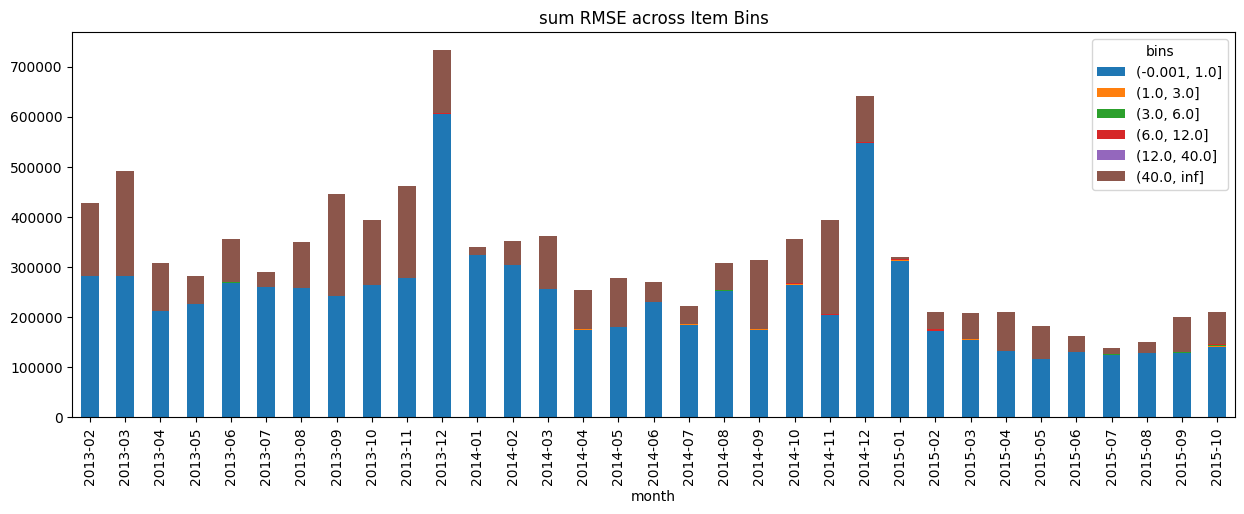

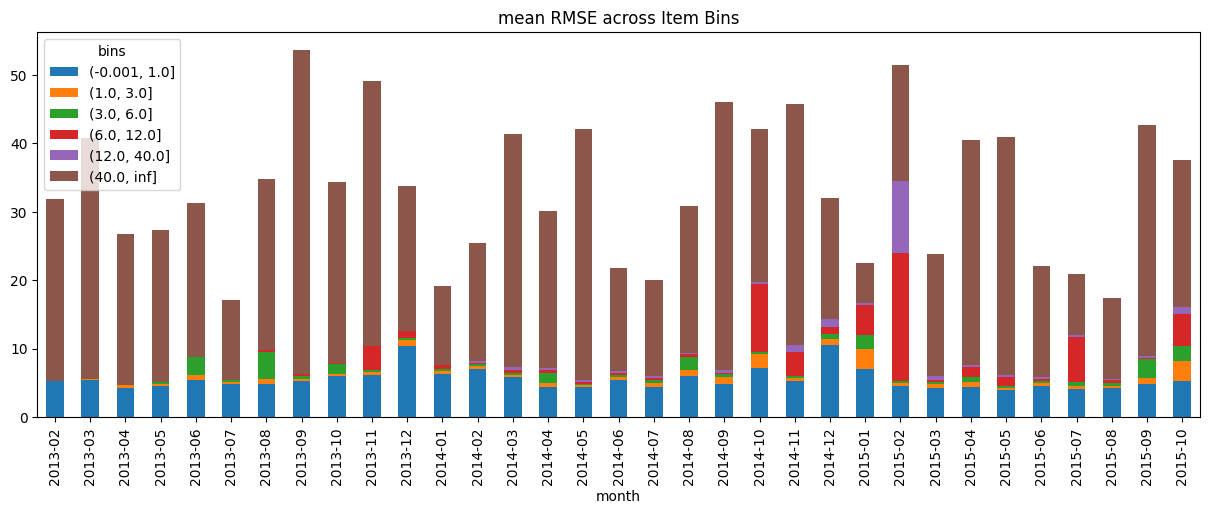

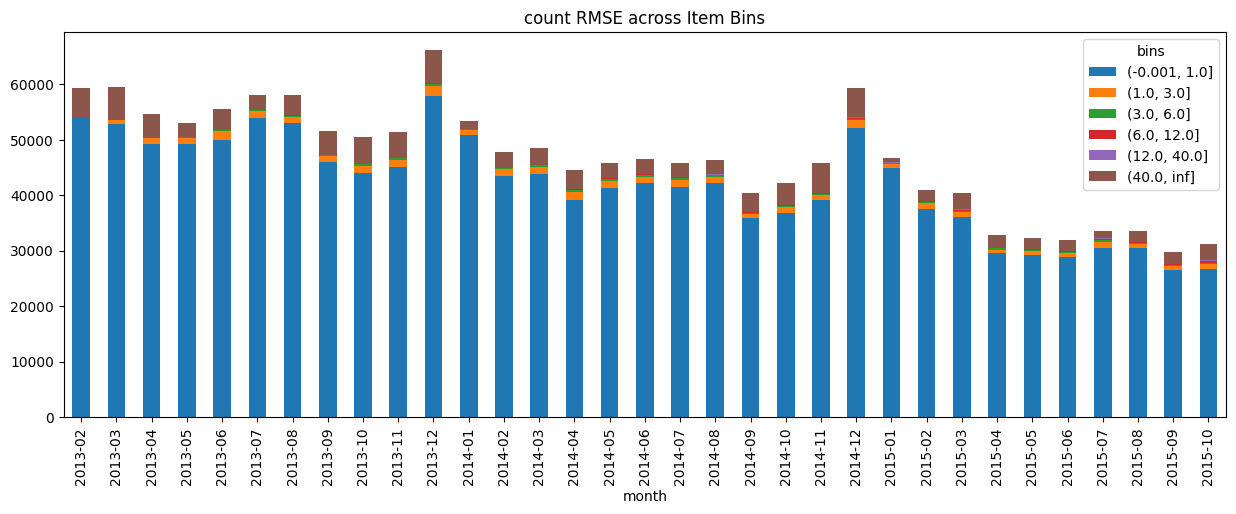

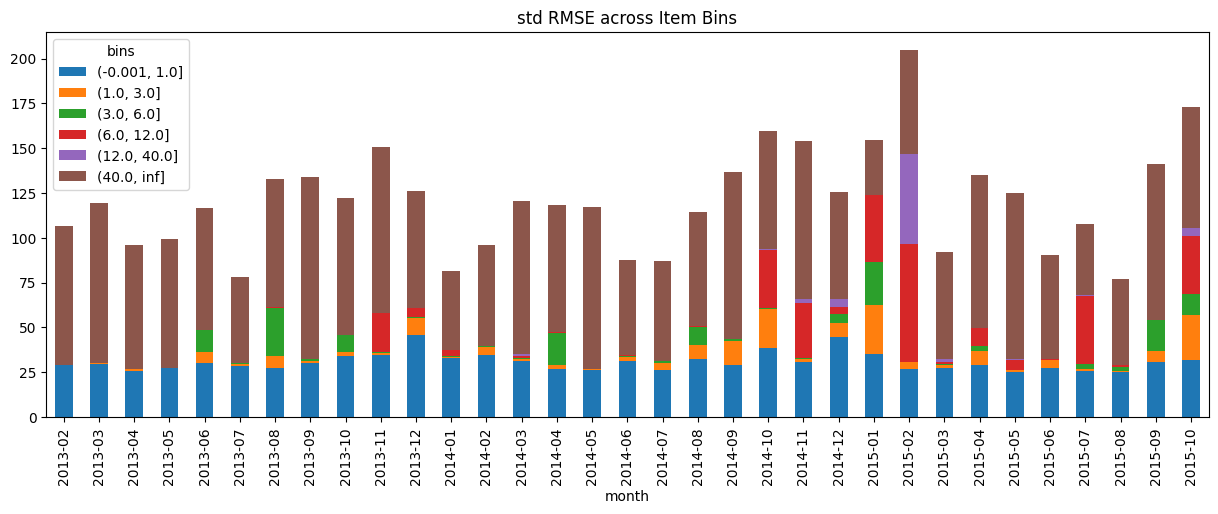

In [ ]:
# Remember, dont use train, only self.train
class BackTester:
    def __init__(self, train):
        date_train = train.copy()
        date_train['date'] = pd.to_datetime(date_train['date'], format='%d.%m.%Y')
        date_train['month'] = date_train['date'].dt.to_period('M')
        date_train = date_train.set_index('month')
        date_train = date_train.sort_index()

        self.train: pd.DataFrame = date_train


    """ 
    Takes in a function
    Function should take
        1. test df
        2. stores list, items list
        3. any optional arguments
    """
    def submit_predictor(self, predictor, **kwargs):
        self.predictor = predictor
        self.additional_args = kwargs
    
    def run_backtester(self):
        months = self.train.index.unique()
        mse_list = []

        for index, month in enumerate(months):
            if index == len(months) - 1: continue # exclude last month (using full train set)
            # if index > 1: continue

            # Get data, calculate answers
            sub_train = self.train.loc[:month, :]
            sub_test = self.train.loc[months[index+1],:]

            train_stores = sub_train['shop_id'].unique()
            test_stores = sub_test['shop_id'].unique()
            test_items = sub_test['item_id'].unique()

            intersection_stores = list(set(train_stores) & set(test_stores))
            filtered_test = sub_test[sub_test['shop_id'].isin(intersection_stores)]

            test_answers = filtered_test.groupby(by=['shop_id', 'item_id'])['item_cnt_day'].sum()
            test_answers = test_answers.to_frame('answer').reset_index()
            test_answers = test_answers.sort_values(by=['shop_id', 'item_id'])
            test_answers['answer'] = np.clip(test_answers['answer'], 0, 20)

            # Call predictor
            # require that there is a 'prediction' column
            prediction = self.predictor(sub_train, intersection_stores, test_items, **self.additional_args)
            assert('prediction' in prediction.columns)

            # Output analytics

            # get the item type
            combined_df = pd.concat([sub_train, sub_test], axis=0)
            month_group = combined_df.groupby(by=['item_id', 'month'])['item_cnt_day'].sum().to_frame('times_sold').reset_index()
            month_group = month_group.sort_values(by=['item_id', 'month'])
            month_group['last_purchase'] = month_group.groupby(by='item_id')['month'].shift(1)
            month_group['time_since_last'] = (month_group['month'].astype('int64') - month_group['last_purchase'].astype('int64'))
            month_group['time_since_last'] = np.where(month_group['time_since_last'] < 0, 100, month_group['time_since_last'])
            month_group['bins'] = pd.cut(month_group['time_since_last'], bins=[0,1,3,6,12, 40,np.inf], include_lowest=True)
            month_group = month_group[month_group['month'] == months[index+1]]

            test_answers = test_answers.merge(right=month_group[['item_id', 'bins']], on=['item_id'])            
            combined = test_answers.merge(right=prediction, on=['shop_id', 'item_id'])
            mse = mean_squared_error(combined['answer'], combined['prediction'])
            print("MSE:", mse)

            # Stats
            # 1. mse stats
            mseBreakdown = combined.groupby(by='bins', observed=True)[['answer', 'prediction']]\
                .apply(lambda group : np.square(group['answer'] - group['prediction']).agg(['sum', 'mean', 'count', 'std']))
            mseBreakdown = mseBreakdown.reset_index()
            mseBreakdown['month'] = months[index+1]
            mse_list.append(mseBreakdown)

            # 2. item category stats
            

        final_stats_df = pd.concat(mse_list, ignore_index=True)
        self.stats = final_stats_df

    def display_stats(self):
        for col in self.stats.columns:
            if col in ['bins', 'month']: continue
            
            pivot_df = self.stats.pivot(index='month', columns='bins', values=col).fillna(0)
            pivot_df.plot(kind='bar', stacked=True, figsize=(15,5))
            plt.title(f'{col} RMSE across Item Bins')

b = BackTester(train)

def predictor(train: pd.DataFrame, stores, items):
    index = pd.MultiIndex.from_product([stores, items], names=['shop_id', 'item_id'])
    result = pd.DataFrame(index=index)
    last_month = train.index.unique().max()

    aggregated_train = train.loc[last_month,:].groupby(by=['shop_id', 'item_id'])['item_cnt_day'].sum().to_frame('prediction').reset_index()
    result = result.merge(aggregated_train, on=['shop_id', 'item_id'], how='left').fillna(0)
    result['prediction'] = np.clip(result['prediction'], 0, 20)
    result['prediction'] = 1.5
    return result

b.submit_predictor(predictor)
b.run_backtester()
b.display_stats()